In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
#import utils 
from utils import draw_weights, selectivity_metric

In [4]:
# Squadrani et al version

class BCM_Model_Curti(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        # learnable params
        self.weights = torch.normal(mean=0, std=(2 / n_in)**(1/2),size=(n_units, n_in), dtype=torch.float64) # http://arxiv.org/abs/1502.01852
        self.threshold = torch.zeros(n_units)

        self.act = nn.ReLU()
        # tracking
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []

    def forward(self, x):
        y = self.act(torch.mm(self.weights, x))
        return y
    
    def update(self, x, gamma=0.5, tau_th=0.09, tau_w = 0.05):
        """_summary_

        Args:
            x (_type_):  shape (n_in, batch_size)
            gamma (_type_, optional): _description_. Defaults to 0.5.
            eps (_type_, optional): _description_. Defaults to 0.05.
            decay (_type_, optional): _description_. Defaults to 1.
        """

        # norm weight ?
      #  self.weights = self.weights/torch.linalg.norm(self.weights)

        # forward pass
        y = self.act(torch.mm(self.weights, x)) # y (n_units, n_batch)

        # calc current threshold 
        cur_threshold = torch.mean(y**2, dim=1) # avg over batch 

        # update threshold using moving avg 
        self.threshold = ( gamma*self.threshold + (1-gamma) * cur_threshold ) * tau_th

        # calc delta W
        t  = self.threshold.reshape(-1, 1)
        delta_w = torch.einsum('ij, jk -> ik', (y * ( y - t ) )  , x.T) / t
        delta_w /= x.shape[1] # normalize the weights update according to the number of samples

        # update weights
        self.weights += delta_w * tau_w  
        print("w", self.weights)

        # tracking
        self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

w tensor([[ 0.0005, -0.0105,  0.0054,  ...,  0.0127,  0.0142, -0.0575],
        [ 0.0310, -0.0190, -0.0842,  ...,  0.0118,  0.0381,  0.0020],
        [-0.0486,  0.0277,  0.0391,  ..., -0.0115, -0.0534, -0.0212],
        ...,
        [ 0.0218,  0.0699, -0.0478,  ..., -0.0517,  0.0300,  0.0055],
        [ 0.0693,  0.0960,  0.0801,  ...,  0.0650,  0.0303, -0.0207],
        [ 0.0511, -0.0013, -0.0391,  ..., -0.0786,  0.0345, -0.0617]],
       dtype=torch.float64)
torch.Size([10, 100])
tensor([65.7901, 65.0288, 66.1065, 55.3258, 64.7017, 66.3154, 65.0137, 65.0844,
        65.0297, 65.4963], dtype=torch.float64)
w tensor([[ 0.0005, -0.0105,  0.0054,  ...,  0.0127,  0.0142, -0.0575],
        [ 0.0310, -0.0190, -0.0842,  ...,  0.0118,  0.0381,  0.0020],
        [-0.0486,  0.0277,  0.0391,  ..., -0.0115, -0.0534, -0.0212],
        ...,
        [ 0.0218,  0.0699, -0.0478,  ..., -0.0517,  0.0300,  0.0055],
        [ 0.0693,  0.0960,  0.0801,  ...,  0.0650,  0.0303, -0.0207],
        [ 0.0511, -0.

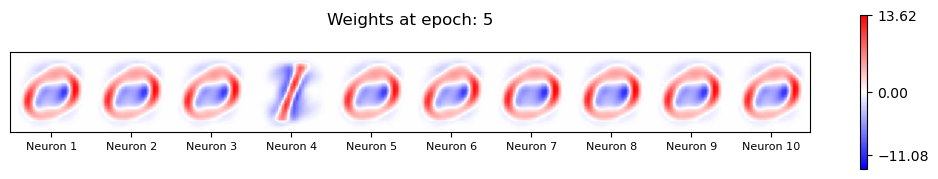

In [201]:


# load data
# data_np = np.loadtxt("gratings.csv", delimiter=",")
# data = torch.from_numpy(data_np)
# n_samples, n_in = data.shape

from sklearn.datasets import fetch_openml
data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
data = torch.tensor(data.to_numpy(), dtype=torch.float64)
data /= 255.
data -= torch.mean(data, dim=0) # balance data around mean 
# for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps #
n_epochs = 5
n_units = 10
batch_size = 100
tau_th = 0.05
tau_w = 0.001

model = BCM_Model_Curti(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch, tau_th=tau_th, tau_w=tau_w)
    draw_weights(model.weights, epoch)



w tensor([[-0.0715, -0.8582, -1.2982,  ...,  0.4348,  0.8909,  0.9199],
        [-0.0072, -0.3294, -0.6178,  ..., -0.0508, -0.0226,  0.1251],
        [ 0.0388, -0.1635, -0.2498,  ...,  0.2348,  0.0736,  0.0566],
        ...,
        [ 0.0861, -0.2895, -0.3043,  ...,  0.3464,  0.2564,  0.2572],
        [-0.0346, -0.2319, -0.3505,  ..., -0.0490,  0.0097,  0.0302],
        [ 0.0147, -0.3534, -0.6462,  ...,  0.2093,  0.4160,  0.4785]],
       dtype=torch.float64)
torch.Size([10, 100])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
w tensor([[-0.0715, -0.8582, -1.2982,  ...,  0.4348,  0.8909,  0.9199],
        [-0.0072, -0.3294, -0.6178,  ..., -0.0508, -0.0226,  0.1251],
        [ 0.0388, -0.1635, -0.2498,  ...,  0.2348,  0.0736,  0.0566],
        ...,
        [ 0.0861, -0.2895, -0.3043,  ...,  0.3464,  0.2564,  0.2572],
        [-0.0346, -0.2319, -0.3505,  ..., -0.0490,  0.0097,  0.0302],
        [ 0.0147, -0.3534, -0.6462,  ...,  0.2093,  0.4160,  0.4785]],
       d

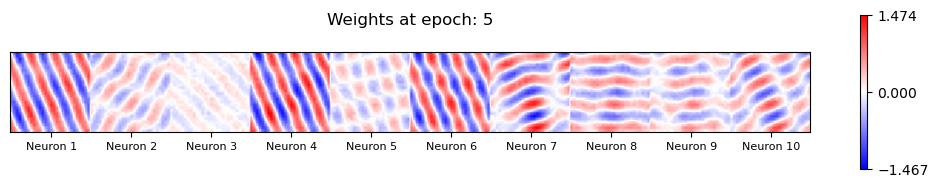

In [202]:


# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# from sklearn.datasets import fetch_openml
# data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
# data = torch.tensor(data.to_numpy(), dtype=torch.float64)
# data /= 255.
# data -= torch.mean(data, dim=0) # balance data around mean 
# # for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps #
n_epochs = 5
n_units = 10
batch_size = 100
tau_th = 0.1
tau_w = 0.05

model = BCM_Model_Curti(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch, tau_th=tau_th, tau_w=tau_w)
    draw_weights(model.weights, epoch)



w tensor([[-0.0304,  0.1465,  0.2116,  ...,  0.2132,  0.3113,  0.2311],
        [-0.0135,  0.2341,  0.4121,  ...,  0.2493,  0.3170,  0.2073],
        [-0.1065,  0.2804,  0.3508,  ..., -0.3313, -0.3146,  0.0101],
        ...,
        [-0.0104,  0.2391,  0.3269,  ...,  0.3184,  0.3645,  0.1810],
        [ 0.0044,  0.0047,  0.0797,  ..., -0.2880, -0.2193, -0.3043],
        [-0.0689,  0.1917,  0.3312,  ...,  0.2234,  0.3509,  0.3347]],
       dtype=torch.float64)
torch.Size([10, 100])
tensor([18.2073, 13.6978, 19.6325, 18.2375, 18.2049, 18.2055, 21.0993, 13.6974,
        18.0202, 22.6323], dtype=torch.float64)
w tensor([[-0.0304,  0.1468,  0.2120,  ...,  0.2135,  0.3118,  0.2317],
        [-0.0135,  0.2326,  0.4099,  ...,  0.2473,  0.3148,  0.2061],
        [-0.1065,  0.2831,  0.3553,  ..., -0.3358, -0.3172,  0.0101],
        ...,
        [-0.0104,  0.2376,  0.3246,  ...,  0.3164,  0.3623,  0.1798],
        [ 0.0044,  0.0047,  0.0797,  ..., -0.2897, -0.2209, -0.3060],
        [-0.0689,  0.

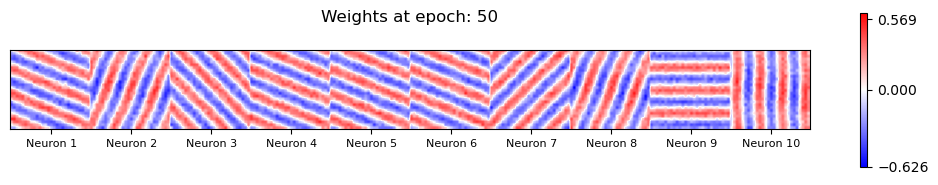

In [67]:


# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# from sklearn.datasets import fetch_openml
# data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
# data = torch.tensor(data.to_numpy(), dtype=torch.float64)
# data /= 255.
# data -= torch.mean(data, dim=0) # balance data around mean 
# for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps #
n_epochs = 50

#n_epochs = 10
n_units = 10
batch_size = 100
#tau_th = 0.09
tau_th = 0.1
tau_w = 0.001

model = BCM_Model_Curti(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch, tau_th=tau_th, tau_w=tau_w)
    draw_weights(model.weights, epoch)



### Visual Analysis

#### Selectivity

In [68]:
sel = np.array(model.selectivity)
sel =sel.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

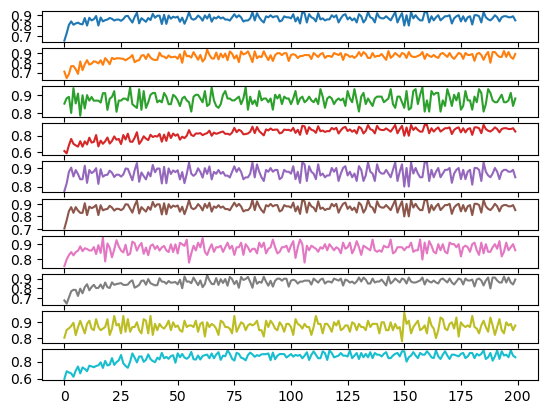

In [69]:
import pandas as pd
sel_df = pd.DataFrame({f'neuron_{i}': sel[i,:] for i in range(n_units)})
sel_df.plot(subplots=True, legend=False)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

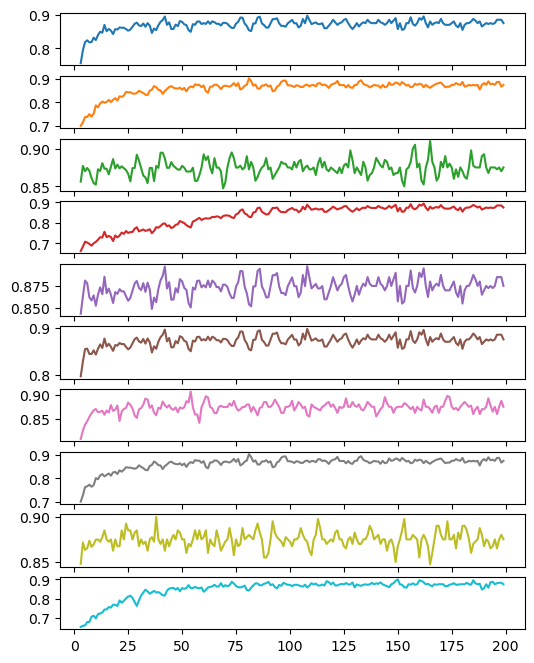

In [70]:
window_size = n_samples // batch_size  # adjust as needed

sel_df = pd.DataFrame({f'neuron_{i}': pd.Series(sel[i,:]).rolling(window=window_size).mean() for i in range(n_units)})
sel_df.plot(subplots=True, legend=False, figsize=(6, n_units-2))


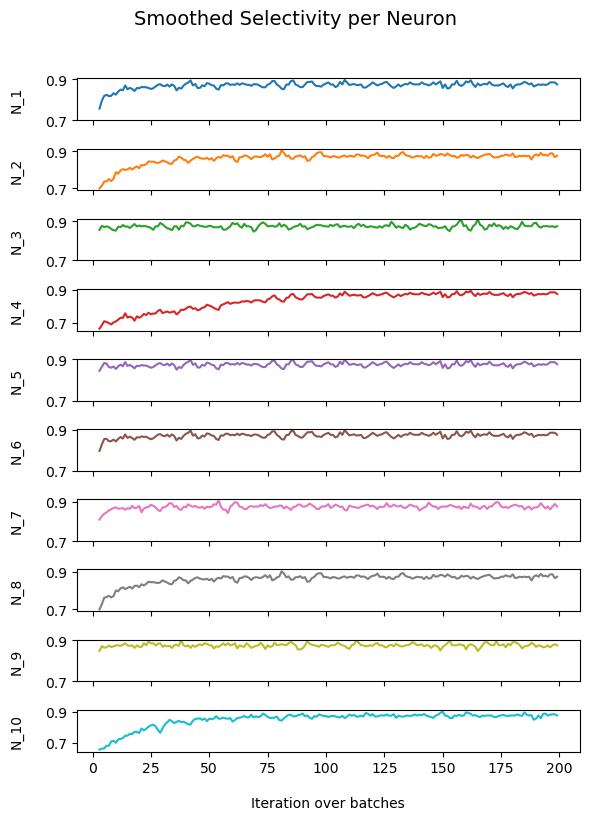

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

window_size = n_samples // batch_size  # adjust as needed

# Smooth and create dataframe
sel_df = pd.DataFrame({f'neuron_{i}': pd.Series(sel[i,:]).rolling(window=window_size).mean() for i in range(n_units)})

# Create subplots
axes = sel_df.plot(subplots=True, legend=False, figsize=(6, n_units-2), title='Smoothed Selectivity per Neuron')

custom_yticks = [0.70, 0.90]


# Loop over axes to set y-labels cleanly
for i, ax in enumerate(axes):
    ax.set_ylabel(f'N_{i+1}', rotation=90, labelpad=20, va='center')
    #ax.yaxis.set_label_position("left")

        # Format y-tick labels to round to 2 decimals
    ax.set_yticks(custom_yticks)
    # y_ticks = ax.get_yticks()
    # ax.set_yticklabels([f"{tick:.2f}" for tick in y_ticks])

ax.set_xlabel(f'Iteration over batches', rotation=0, labelpad=20, va='center')

# Set a single super-title if you prefer
plt.suptitle('Smoothed Selectivity per Neuron', fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


#### Threshold

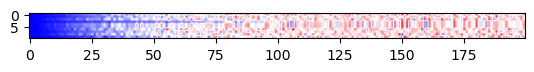

In [72]:
t = np.array(model.threshold_trace)
t = t.T
plt.imshow(t,cmap='bwr')

In [73]:
t.shape

(10, 200)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

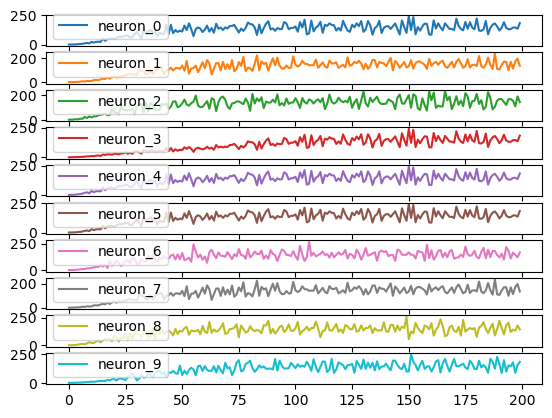

In [74]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': t[i, :] for i in range(n_units)})
df.plot(subplots=True)

#### Activations

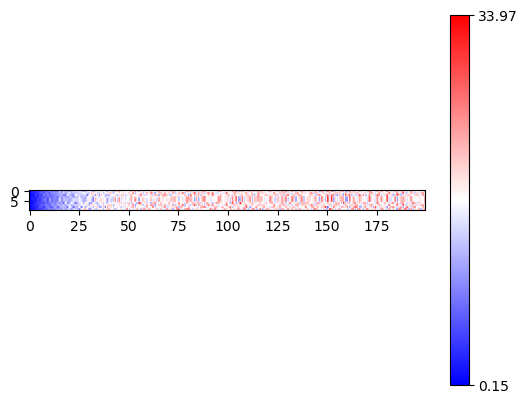

In [75]:
y = np.array(model.activations)
y = y.T
plt.imshow(y,cmap='bwr')
plt.colorbar( ticks=[np.amin(y), 0, np.amax(y)])

In [76]:
y.shape

(10, 200)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

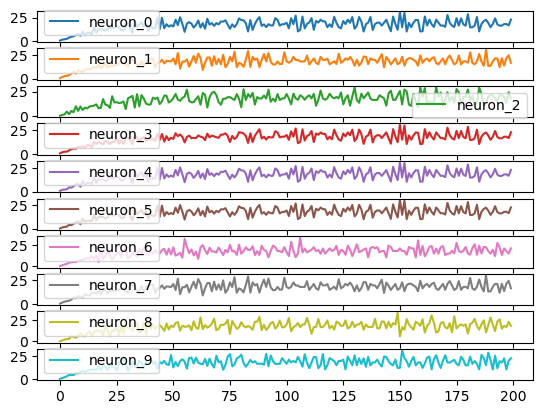

In [77]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': y[i, :] for i in range(n_units)})
df.plot(subplots=True)

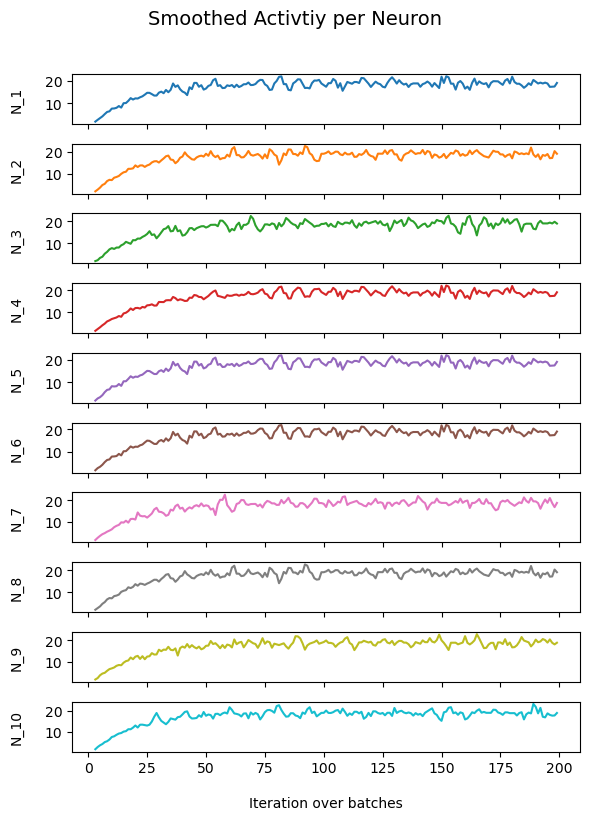

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

window_size = n_samples // batch_size  # adjust as needed

# Smooth and create dataframe
act_df = pd.DataFrame({f'neuron_{i}': pd.Series(y[i,:]).rolling(window=window_size).mean() for i in range(n_units)})

# Create subplots
axes = act_df.plot(subplots=True, legend=False, figsize=(6, n_units-2), title='Smoothed Selectivity per Neuron')

custom_yticks = [10, 20]


# Loop over axes to set y-labels cleanly
for i, ax in enumerate(axes):
    ax.set_ylabel(f'N_{i+1}', rotation=90, labelpad=20, va='center')
    #ax.yaxis.set_label_position("left")

        # Format y-tick labels to round to 2 decimals
    ax.set_yticks(custom_yticks)
    # y_ticks = ax.get_yticks()
    # ax.set_yticklabels([f"{tick:.2f}" for tick in y_ticks])

ax.set_xlabel(f'Iteration over batches', rotation=0, labelpad=20, va='center')

# Set a single super-title if you prefer
plt.suptitle('Smoothed Activtiy per Neuron', fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


#### Comparing Threshold & Activity 

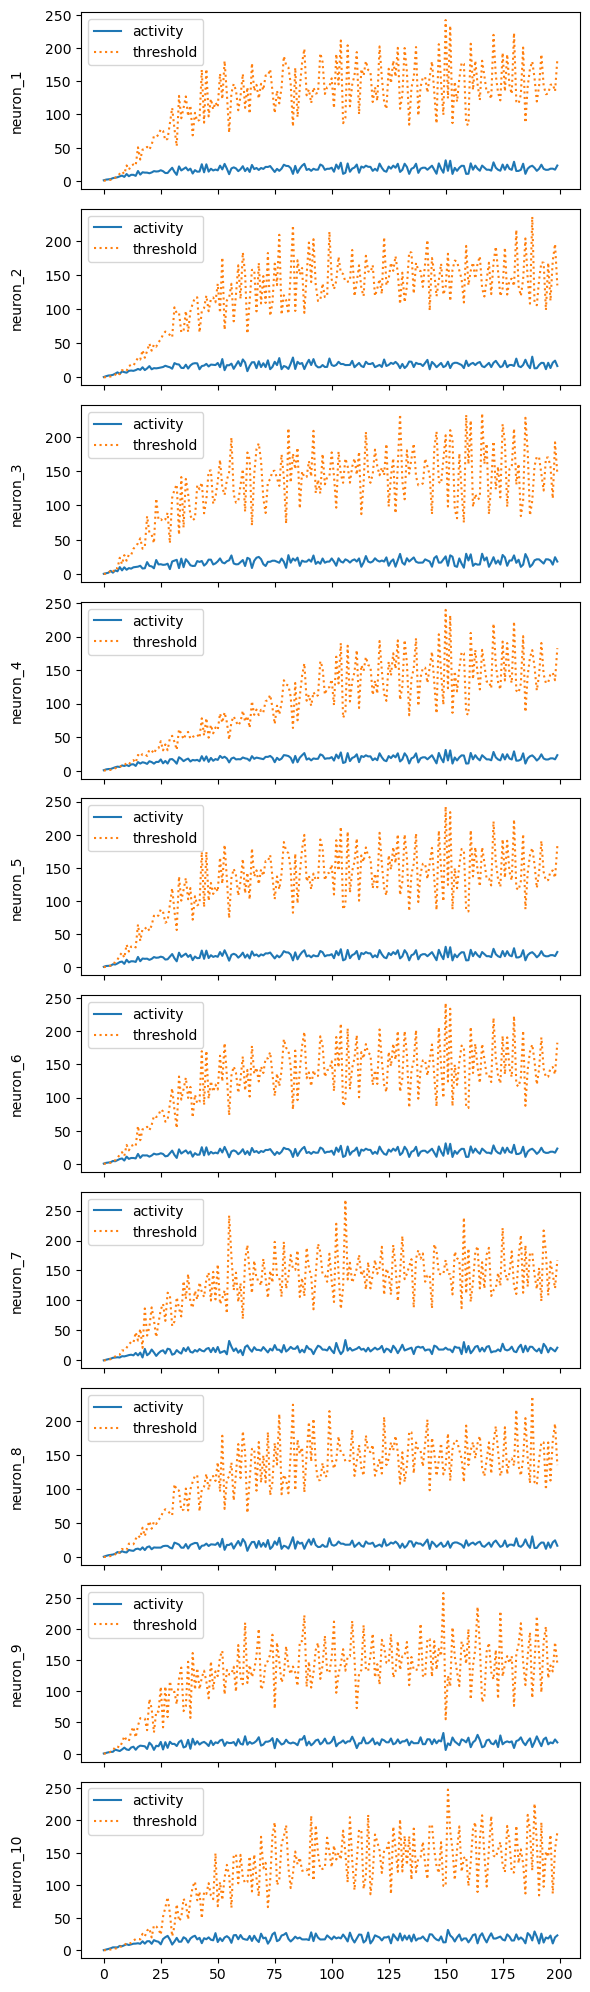

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y and t are numpy arrays of shape (n_units, timepoints)
n_units = y.shape[0]

# Create subplots
fig, axes = plt.subplots(n_units, 1, figsize=(6, n_units*2), sharex=True)

# Loop over neurons
for i in range(n_units):
    ax = axes[i]
    
    # Plot activity
    ax.plot(y[i, :], label='activity')
    
    # Plot threshold (dotted)
    ax.plot(t[i, :], linestyle=':', label='threshold')
    
    # Set y-label as neuron label
    ax.set_ylabel(f'neuron_{i+1}', rotation=90, labelpad=20, va='center')
    
    # Optionally remove legend if labels are clear
    ax.legend()

plt.tight_layout()
plt.show()


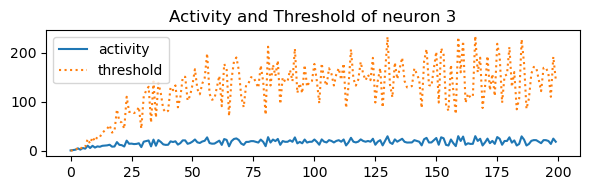

In [88]:
import matplotlib.pyplot as plt

# Select neuron index 5 (6th neuron)
i = 2

fig, ax = plt.subplots(figsize=(6, 2))

# Plot activity
ax.plot(y[i, :], label='activity')

# Plot threshold (dotted)
ax.plot(t[i, :], linestyle=':', label='threshold')

# Set y-label as neuron label
#x.set_ylabel(f'neuron_{i}', rotation=0, labelpad=40, va='center')
plt.title(f"Activity and Threshold of neuron {i+1}")
# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [89]:
import seaborn as sns

In [90]:
y.shape

(10, 200)

In [91]:
y[i,:]

array([ 0.23446563,  1.02126928,  1.76878655,  4.52076669,  1.8712334 ,
        5.18844089,  3.86355848,  9.98997571,  5.24120696,  9.72279046,
        6.11288707,  8.52815313,  7.74910411,  9.71892412, 10.14875236,
       10.64557577, 11.94091263,  7.97379688,  8.34798107, 17.29465175,
       11.72434013, 11.03881211,  8.27271826, 20.3512366 , 13.91848489,
       14.19661906, 13.27665524, 13.58303814, 14.95557724,  7.08196916,
       18.18954341, 19.45734815, 20.6363403 ,  8.52610544, 22.43162111,
        9.89624728, 21.48969673, 17.63961223, 12.65465838, 11.63292515,
       11.86223594, 18.82800386, 17.51017404, 18.94296038, 12.21376409,
       15.16594898, 20.89200333, 20.81226529, 13.8237961 , 15.39741984,
       18.38172215, 22.66272962, 16.85481245, 15.51572825, 18.52074609,
       19.9633549 , 27.01392544, 15.33222005, 14.04588332, 14.24889944,
       17.30288171, 20.29677582, 11.57760595, 23.54378024, 21.83199605,
        8.68594324, 19.2311811 , 23.6935161 , 24.87022426, 21.59

In [92]:
t[i,:]

array([1.53700430e-02, 3.80812799e-01, 1.29312422e+00, 5.06251334e+00,
       2.77219040e+00, 8.89776283e+00, 8.05845323e+00, 2.36543647e+01,
       1.41363591e+01, 2.74358861e+01, 1.93561256e+01, 2.83457383e+01,
       2.77295463e+01, 3.66153418e+01, 4.07763565e+01, 4.46322583e+01,
       5.19828618e+01, 3.68022808e+01, 3.94248884e+01, 8.42865551e+01,
       6.01415392e+01, 5.72329318e+01, 4.48362304e+01, 1.10123092e+02,
       7.89650328e+01, 8.00226582e+01, 7.67624736e+01, 7.96053669e+01,
       8.92689284e+01, 4.49732218e+01, 1.11203439e+02, 1.22926403e+02,
       1.30617896e+02, 5.72838887e+01, 1.41380938e+02, 6.75723365e+01,
       1.38643941e+02, 1.16993946e+02, 8.50855164e+01, 7.82726636e+01,
       8.13033211e+01, 1.29711045e+02, 1.23577762e+02, 1.33386778e+02,
       8.85415200e+01, 1.08221662e+02, 1.50255445e+02, 1.51080674e+02,
       1.02320463e+02, 1.12201123e+02, 1.34837461e+02, 1.66532350e+02,
       1.25905416e+02, 1.15212513e+02, 1.36950441e+02, 1.48666930e+02,
      

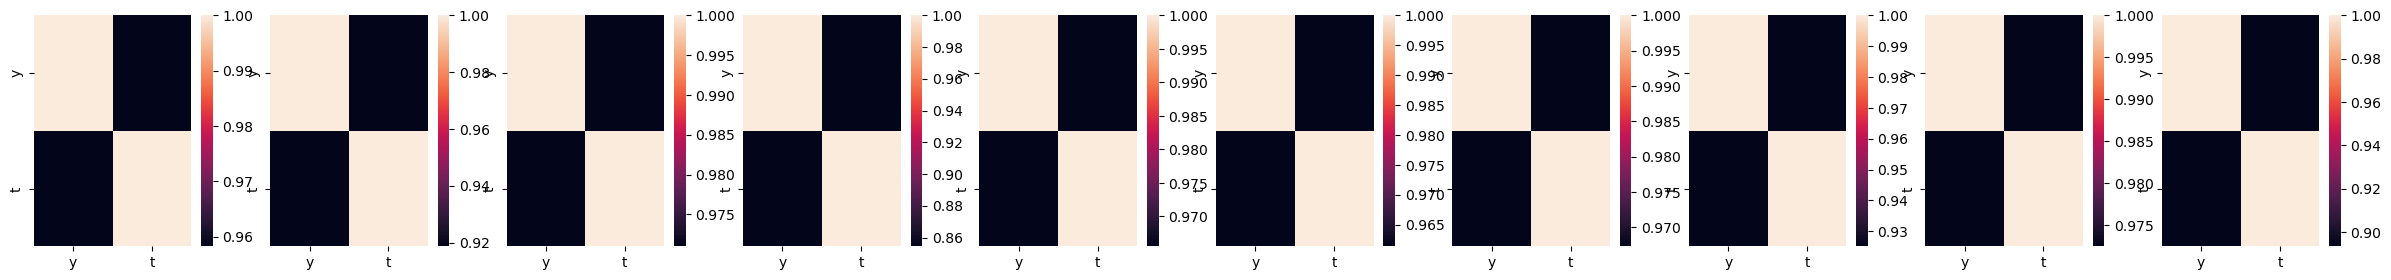

In [93]:
n_cols = n_units  # number of columns in subplot grid
n_rows = 1 # compute number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(n_units):
    df = pd.DataFrame({'y':y[i,:], 't':t[i,:]})
    cor = df.corr()
    sns.heatmap(cor, ax= axes[i])